In [1]:
import itertools
import random
import math

from z3 import *
from collections import defaultdict

## La Génération de Tests
Avec l’évolution de la taille et de la complexité des logiciels, ingénieurs et chercheurs se sont tournés vers la génération automatique de tests, en introduisant des méthodes formelles ou basées sur des modèles. On distingue généralement deux grandes catégories principales :

- Le testing en boîte noire (black-box) : les tests sont générés à partir des spécifications fonctionnelles, comme les domaines de définition des entrées ou les codes de retour attendus. Le code source n’est pas pris en compte.

- Le testing en boîte blanche (white-box) : cette approche s’appuie sur l’analyse du code lui-même. On génère des tests en se basant sur les chemins d’exécution, les branches conditionnelles et la structure du programme, dans le but d’en maximiser la couverture.

On retrouve également des approches entièrement basées sur des modèles, comme les diagrammes UML, qui décrivent le comportement attendu du système. Ces modèles servent alors de base pour générer automatiquement les cas de test.

En ce qui concerne les techniques utilisées, plusieurs approches se démarquent :

- L’exécution symbolique et la programmation par contraintes : on explore les chemins du programme à l’aide d’entrées symboliques, en résolvant les contraintes associées à chaque chemin. Des outils comme KLEE qui est un moteur d’exécution symbolique basé sur LLVM, permettent de générer automatiquement des tests à forte couverture en analysant le comportement du binaire.

- Les méthodes de recherche : par exemple, les algorithmes génétiques et autres techniques d’optimisation permettent de générer des tests visant des objectifs précis (comme maximiser la couverture).

- Les techniques aléatoires, ou fuzzing, injectent des données générées de manière semi-aléatoire dans le système pour détecter des comportements imprévus, notamment en matière de sécurité.

- Les approches basées sur des grammaires exploitent des descriptions formelles (par exemple en BNF) du format des entrées pour générer des cas de test valides.

Enfin, des méthodes plus récentes s’appuient sur le machine learning, qui permet de guider la génération de tests en fonction du comportement observé ou de prédictions sur les zones potentiellement fautives du code.

## Les Tests d'intéraction Combinatoires
Le test d'interaction combinatoire est une technique utilisée pour étudier comment les combinaisons de paramètres d'entrée influencent la couverture du code. Elle est particulièrement utile pour échantillonner des cas de test lorsque le nombre total de combinaisons possibles est trop grand pour être testé de manière exhaustive. Plutôt que de tester toutes les configurations possibles, on se concentre sur des combinaisons sélectionnées de manière stratégique, susceptibles de révéler des défauts.

Il s'agit d'une technique de type *boîte noire*, ce qui signifie que l’on ne s’appuie pas sur la structure interne du logiciel pour choisir les tests. Le test d’interaction combinatoire est également connu sous le nom de *test t-uplet*, où *t* désigne le nombre de paramètres impliqués dans chaque interaction. Par exemple, un test par paires correspond à un test 2-uplet, où toutes les paires possibles de valeurs de paramètres sont couvertes au moins une fois.

### Les Problèmes Combinatoires dans le Contexte de la Programmation Par Contrainte
La combinatoire joue un rôle central en informatique, notamment dans les domaines qui impliquent des structures discrètes et l’exploration efficace de grands espaces de recherche. En test logiciel, elle permet de raisonner sur des ensembles minimaux de cas de test tout en garantissant une bonne couverture.

## Les Tests d'Intéraction Combinatoires Basées sur Code
Dans l'approche qui suit, nous ne traitons pas le logiciel sous test (SUT) comme une boîte noire complète. Nous adoptons plutôt une perspective de *boîte grise*, où nous analysons comment chaque paramètre influence le comportement ou la couverture. Cela nous permet de guider le processus de génération de tests de manière plus intelligente, en l’optimisant à l’aide de solveurs et de techniques de satisfaction de contraintes. En intégrant ces informations, nous réduisons la redondance, ciblons les combinaisons les plus informatives et améliorons l’efficacité de la suite de tests tout en maintenant sa taille à un niveau raisonnable.

### Concepts de base
#### Le tableau combinatoire
Un ensemble de tests combinatoires repose sur un concept mathématique bien connu appelé *CA* (Array Combinatoire). Dans ce contexte, chaque ligne du *CA* représente un cas de test et chaque colonne représente un paramètre d'entrée du système à tester (SUT). Formellement, un *CA<sub>λ</sub>(N; t, k, v)* est un tableau de dimensions N × k avec des valeurs provenant de l'ensemble {0, 1, ..., v-1}, où chaque combinaison de *t* paramètres parmi les *k* colonnes doit apparaître au moins *λ* fois. Plus précisément, chaque sous-tableau N × t doit contenir tous les sous-ensembles ordonnés de taille *t* provenant de l'ensemble des *v* valeurs, et ce, au moins *λ* fois.

En termes simples, un *CA* garantit que chaque combinaison de *t* paramètres apparaît suffisamment souvent, chaque combinaison spécifique apparaissant au moins *λ* dans le tableau.

Spécialement, pour les cas où le nombre de valeurs possibles varie par paramètre, on utilise une extension de cette structure nommée MCA pour "Mixed Combinatorial Array" définie comme MCA (N;t,k,(v<sub>1</sub>, v<sub>2</sub>, ..., v<sub>k</sub>))
#### Le contexte 
Nous appliquons notre méthode sur des SUT pouvant être testés à l'aide de notre approche, notamment les logiciels à entrées idéalement discrètes, finies ou catégorisables, et à sorties déterministes.


#### La méthode
On commence par mesurer la couverture du code en fonction de la variation d’un certain nombre de paramètres. En règle générale, pour évaluer l’impact d’un paramètre, on garde tous les autres constants et on ne fait varier que celui-ci. Cependant, cette méthode peut masquer le fait qu’une partie de la couverture est due aux valeurs fixes choisies pour les autres paramètres.

C’est pourquoi nous adoptons plutôt une analyse t-way, dans laquelle on mesure l’impact en faisant varier simultanément t paramètres. Cela nous permet ensuite de construire une matrice de corrélation entre les paramètres et, en fonction de ces corrélations, d’attribuer un impact individuel à chaque paramètre. Cette approche nous aide à minimiser le nombre de tests tout en conservant une couverture maximale entre les paires de paramètres.

Les paramètres les plus corrélés sont ensuite soumis à une seconde génération d’analyse t-way, avec une valeur de t plus élevée, afin d’encourager leur exploration.

Pour une meilleure vue d’ensemble de la méthode, on peut se référer à la figure suivante : 

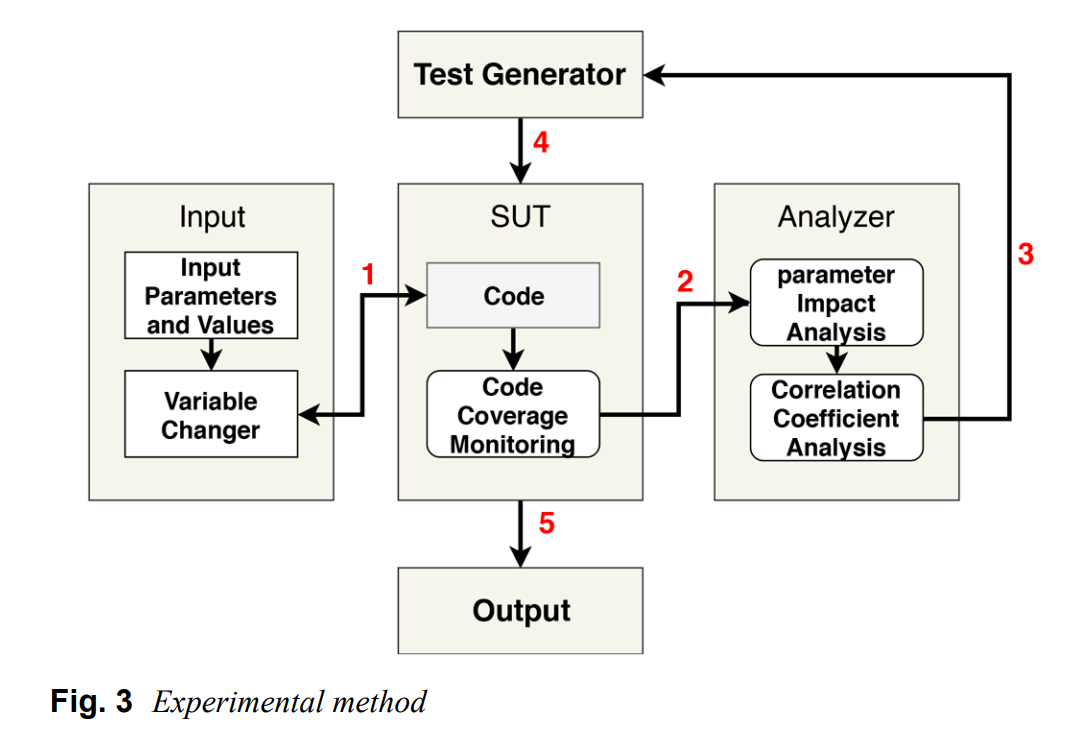

### L'implémentation
- Extraction des paramètres et des domaines (avec contraintes) de la fonction à tester, pour démonstration on présente l'exemple suivant:

In [2]:
params = [
    "Type",
    "Size",
    "Format method",
    "File system",
    "Cluster size",
    "Compression",
]

values = {
    "Type": [1, 2, 3],
    "Size": [1, 2, 3],
    "Format method": [1, 2],
    "File system": [1, 2, 3],
    "Cluster size": [1, 2, 3],
    "Compression": [1, 2],
}

# Constraints using index-based logic
def constraint1(v):
    return Implies(
        v["Type"] == values["Type"].index(2),
        v["Compression"] == values["Compression"].index(1),
    )

def constraint2(v):
    return Implies(
        v["Size"] >= values["Size"].index(1),
        v["Format method"] == values["Format method"].index(2),
    )

constraints = [constraint1, constraint2]

- Identification des impacts des pairs de variables sur la couverture du code (et création de l'objet CA):

In [3]:
def t_wise_testing(params, values, constraints, t=2):
    """
    Generate a t-wise test suite using Z3 with constraint handling.

    Args:
        params (list): List of parameter names.
        values (dict): Dictionary mapping each parameter to a list of possible values.
        constraints (list): List of constraint functions taking Z3 variables.
        t (int): The strength of interaction (e.g., 2 for pairwise, 3 for 3-wise).

    Returns:
        list: A list of test cases (dicts mapping parameter names to values).
    """

    def create_base_solver():
        z3_vars = {p: Int(p) for p in params}
        s = Solver()
        for p in params:
            s.add(z3_vars[p] >= 0, z3_vars[p] < len(values[p]))
        for c in constraints:
            s.add(c(z3_vars))
        return s, z3_vars

    # Generate all t-wise parameter combinations
    param_combos = list(itertools.combinations(params, t))

    # Track uncovered value combinations for each t-wise parameter combination
    uncovered = {}
    for combo in param_combos:
        value_combos = list(itertools.product(*(values[p] for p in combo)))
        uncovered[combo] = set(value_combos)

    pairs = []
    test_suite = []

    while any(uncovered[combo] for combo in param_combos):
        # Find the parameter combo with the most uncovered value combinations
        best_combo = max(uncovered.items(), key=lambda x: len(x[1]) if x[1] else -1)[0]
        value_combos = list(uncovered[best_combo])
        random.shuffle(value_combos)

        found = False
        for val_combo in value_combos:
            s, z3_vars = create_base_solver()
            for p, v in zip(best_combo, val_combo):
                s.add(z3_vars[p] == values[p].index(v))
            if s.check() == sat:
                found = True
                break
            else:
                uncovered[best_combo].remove(val_combo)

        if not found:
            continue


        # Build partial test case from the chosen t-wise combination
        test_case = {p: v for p, v in zip(best_combo, val_combo)}
        assigned = set(test_case.keys())

        s, z3_vars = create_base_solver()
        for p, v in test_case.items():
            s.add(z3_vars[p] == values[p].index(v))

        # Assign remaining parameters
        for p in params:
            if p in assigned:
                continue
            candidates = []
            for v in values[p]:
                s.push()
                s.add(z3_vars[p] == values[p].index(v))
                if s.check() == sat:
                    # Score based on how many new t-wise combinations this value would cover
                    score = 0
                    for combo in param_combos:
                        if p not in combo:
                            continue
                        if all(param in test_case for param in combo if param != p):
                            full_combo = tuple(
                                test_case[param] if param != p else v for param in combo
                            )
                            if full_combo in uncovered[combo]:
                                score += 1
                    candidates.append((v, score))
                s.pop()
            if not candidates:
                raise Exception(f"No valid value for parameter {p} under constraints.")
            max_score = max(c[1] for c in candidates)
            best_vals = [v for v, s in candidates if s == max_score]
            chosen_val = random.choice(best_vals)
            test_case[p] = chosen_val
            s.add(z3_vars[p] == values[p].index(chosen_val))


        # Add the test case to the suite if it's not already present
        sorted_test_case = {k: test_case[k] for k in sorted(test_case.keys())}
        if sorted_test_case not in [dict(sorted(tc.items())) for tc in test_suite]:
            test_suite.append(sorted_test_case)
            
        # Update uncovered combinations
        for combo in param_combos:
            if all(p in test_case for p in combo):
                val_combo = tuple(test_case[p] for p in combo)
                uncovered[combo].discard(val_combo)

    return test_suite

In [4]:
test_suite = t_wise_testing(params, values, constraints, t=2)
# Printing the resulting test suite
print("\nINITIAL CA\n")
for idx, test_case in enumerate(test_suite):
    print(f"Test {idx + 1}: {test_case}")


INITIAL CA

Test 1: {'Cluster size': 2, 'Compression': 2, 'File system': 1, 'Format method': 2, 'Size': 3, 'Type': 3}
Test 2: {'Cluster size': 1, 'Compression': 1, 'File system': 2, 'Format method': 2, 'Size': 1, 'Type': 2}
Test 3: {'Cluster size': 3, 'Compression': 2, 'File system': 3, 'Format method': 2, 'Size': 2, 'Type': 1}
Test 4: {'Cluster size': 2, 'Compression': 1, 'File system': 3, 'Format method': 2, 'Size': 1, 'Type': 3}
Test 5: {'Cluster size': 2, 'Compression': 1, 'File system': 1, 'Format method': 2, 'Size': 2, 'Type': 2}
Test 6: {'Cluster size': 2, 'Compression': 1, 'File system': 2, 'Format method': 2, 'Size': 3, 'Type': 1}
Test 7: {'Cluster size': 1, 'Compression': 2, 'File system': 2, 'Format method': 2, 'Size': 2, 'Type': 3}
Test 8: {'Cluster size': 1, 'Compression': 1, 'File system': 3, 'Format method': 2, 'Size': 3, 'Type': 1}
Test 9: {'Cluster size': 3, 'Compression': 1, 'File system': 2, 'Format method': 2, 'Size': 3, 'Type': 2}
Test 10: {'Cluster size': 3, 'Com

- Calcul des couvertures de code correspondantes au CA (en passant par le locating array, l'association des tests aux pairs). Notez que la couverture est simulée pour cette démonstration:

In [5]:
def get_coverage(test):
    return {f"{param}={value}" for param, value in test.items()}

def build_locating_array_matrix(test_array, param_values, display=False):
    """
    From a test array and parameter values, builds a locating array matrix:
    mapping each 2-way pair to the list of test case indices that cover it.

    Args:
        test_array (list[dict]): List of test cases as dicts {param: value}.
        param_values (dict): Dictionary of parameter: list of possible values.

    Returns:
        dict: Mapping from ((p1, v1), (p2, v2)) to list of test indices.
    """
    params = list(param_values.keys())
    param_pairs = list(itertools.combinations(params, 2))

    # Store where each pair appears
    locating_array = defaultdict(list)

    for idx, test in enumerate(test_array):
        for (p1, p2) in param_pairs:
            v1, v2 = test[p1], test[p2]
            key = ((p1, v1), (p2, v2))
            locating_array[key].append(idx)

    if display:
        print("\nLOCATING ARRAY")
        print(f"\n{'Pair':<50} | Covered in Test Indices")
        print("-" * 85)
        for pair, indices in sorted(locating_array.items()):
            pair_str = f"({pair[0][0]}={pair[0][1]}, {pair[1][0]}={pair[1][1]})"
            print(f"{pair_str:<50} | {indices}")

    return locating_array

def get_pair_coverages(locating_array, test_array, param_values, display=False):
    """
    Builds and prints a 2-way pair coverage matrix based on actual test coverage data.

    Args:
        locating_array (dict): Mapping from ((p1, v1), (p2, v2)) to list of test indices.
        test_array (list[dict]): The test suite, each test is a dict of parameter: value.
        param_values (dict): Dictionary of parameter: list of possible values.
        display (bool): Whether to print the matrix.

    Returns:
        dict: Mapping from ((p1, v1), (p2, v2)) to number of intersected coverage lines.
    """
    # Precompute coverage for all tests
    test_coverages = [get_coverage(test) for test in test_array]

    # For each pair, compute the number of intersected lines
    pair_coverage_matrix = {}
    for pair, test_indices in locating_array.items():
        coverages = [test_coverages[i] for i in test_indices]
        total_coverage = set()
        for cov in coverages:
            for line in cov:
                total_coverage.add(line)
        pair_coverage_matrix[pair] = len(total_coverage)

    if display:
        print("\nPAIR COVERAGE TABLE")
        print(f"\n{'Pair':<50} | Test Indices       | #Intersected Lines")
        print("-" * 100)
        for pair, test_indices in locating_array.items():
            count = pair_coverage_matrix[pair]
            pair_str = f"({pair[0][0]}={pair[0][1]}, {pair[1][0]}={pair[1][1]})"
            indices_str = ", ".join(str(i) for i in test_indices)
            print(f"{pair_str:<50} | [{indices_str:<15}] | {count}")

    return pair_coverage_matrix

In [6]:
locating_array = build_locating_array_matrix(test_suite, values, display=True)


LOCATING ARRAY

Pair                                               | Covered in Test Indices
-------------------------------------------------------------------------------------
(Cluster size=1, Compression=1)                    | [1, 7, 10]
(Cluster size=1, Compression=2)                    | [6, 12]
(Cluster size=2, Compression=1)                    | [3, 4, 5]
(Cluster size=2, Compression=2)                    | [0]
(Cluster size=3, Compression=1)                    | [8, 11]
(Cluster size=3, Compression=2)                    | [2, 9]
(File system=1, Cluster size=1)                    | [12]
(File system=1, Cluster size=2)                    | [0, 4]
(File system=1, Cluster size=3)                    | [9, 11]
(File system=1, Compression=1)                     | [4, 11]
(File system=1, Compression=2)                     | [0, 9, 12]
(File system=2, Cluster size=1)                    | [1, 6]
(File system=2, Cluster size=2)                    | [5]
(File system=2, Cluster size=3)  

In [7]:
pair_coverages = get_pair_coverages(locating_array, test_suite, values, display=True)


PAIR COVERAGE TABLE

Pair                                               | Test Indices       | #Intersected Lines
----------------------------------------------------------------------------------------------------
(Type=3, Size=3)                                   | [0, 11          ] | 8
(Type=3, Format method=2)                          | [0, 3, 6, 11, 12] | 13
(Type=3, File system=1)                            | [0, 11, 12      ] | 10
(Type=3, Cluster size=2)                           | [0, 3           ] | 9
(Type=3, Compression=2)                            | [0, 6, 12       ] | 9
(Size=3, Format method=2)                          | [0, 5, 7, 8, 10, 11] | 13
(Size=3, File system=1)                            | [0, 11          ] | 8
(Size=3, Cluster size=2)                           | [0, 5           ] | 9
(Size=3, Compression=2)                            | [0              ] | 6
(Format method=2, File system=1)                   | [0, 4, 9, 11, 12] | 13
(Format method=2, Cluster s

- Analyse d'impacts:

In [8]:
def get_pair_impact(pair_coverage_matrix, display=False):
    """
    Calculate the difference between the maximum and minimum coverage for each parameter pair
    from the given pair coverage matrix.

    Args:
        pair_coverage_matrix (dict): Mapping from pairs ((param1, value1), (param2, value2)) to intersection size.

    Returns:
        dict: Mapping from parameter pairs ((param1, param2)) to the coverage difference (max - min) across the pairs.
    """
    # Initialize a dictionary to store coverage values for each parameter pair
    param_pair_coverage_map = {}

    # Collect coverage values for each parameter pair across all pairs it appears in
    for pair, coverage in pair_coverage_matrix.items():
        param_pair = (pair[0][0], pair[1][0])  # Extract parameter pair (param1, param2)
        if param_pair not in param_pair_coverage_map:
            param_pair_coverage_map[param_pair] = []
        param_pair_coverage_map[param_pair].append(coverage)

    if display:
        # Print collected coverage values for each parameter pair
        print("\nCOLLECTED COVERAGE VALUES FOR EACH PARAMETER PAIR:\n")
        for param_pair, coverages in param_pair_coverage_map.items():
            print(f"{param_pair}: {coverages}")

    # Calculate the difference between max and min coverage for each parameter pair
    param_pair_coverage_diff_map = {}
    for param_pair, coverages in param_pair_coverage_map.items():
        max_coverage = max(coverages)
        min_coverage = min(coverages)
        param_pair_coverage_diff_map[param_pair] = max_coverage - min_coverage

    if display:
        print
        print("\nCOVERAGE DIFFERENCES FOR EACH PARAMETER PAIR (MAX - MIN):\n")
        for param_pair, diff in param_pair_coverage_diff_map.items():
            print(f"{param_pair}: {diff}")

    return param_pair_coverage_diff_map


def get_param_impact(pair_coverage_matrix, display=False):
    """
    Calculate the difference between the maximum and minimum coverage for each parameter
    (across all its value-pairs) from the given pair coverage matrix.

    Args:
        pair_coverage_matrix (dict): Mapping from pairs ((param1, value1), (param2, value2)) to intersection size.

    Returns:
        dict: Mapping from parameter to the coverage difference (max - min) across its values.
    """
    # Initialize a dictionary to store coverage values for each parameter
    param_coverage_map = {}

    # Collect coverage values for each parameter across all pairs it appears in
    for pair, coverage in pair_coverage_matrix.items():
        for (param, value) in pair:
            if param not in param_coverage_map:
                param_coverage_map[param] = []
            param_coverage_map[param].append(coverage)

    if display:
        # Print collected coverage values for each parameter
        print("\nCOLLECTED COVERAGE VALUES FOR EACH PARAMETER:\n")
        for param, coverages in param_coverage_map.items():
            print(f"{param}: {coverages}")

    # Calculate the difference between max and min coverage for each parameter
    param_coverage_diff_map = {}
    for param, coverages in param_coverage_map.items():
        max_coverage = max(coverages)
        min_coverage = min(coverages)
        param_coverage_diff_map[param] = max_coverage - min_coverage

    if display:
        # Print coverage differences for each parameter
        print("\nCOVERAGE DIFFERENCES FOR EACH PARAMETER (MAX - MIN):\n")
        for param, diff in param_coverage_diff_map.items():
            print(f"{param}: {diff}")

    return param_coverage_diff_map

In [9]:
pair_impacts = get_pair_impact(pair_coverages, display=True)


COLLECTED COVERAGE VALUES FOR EACH PARAMETER PAIR:

('Type', 'Size'): [8, 6, 6, 6, 6, 8, 7, 8, 6]
('Type', 'Format method'): [13, 12, 13]
('Type', 'File system'): [10, 8, 9, 6, 6, 6, 6, 6, 6]
('Type', 'Cluster size'): [9, 8, 8, 6, 6, 7, 6, 6, 6]
('Type', 'Compression'): [9, 12, 8, 9, 8]
('Size', 'Format method'): [13, 13, 13]
('Size', 'File system'): [8, 6, 6, 6, 9, 8, 6, 7, 6]
('Size', 'Cluster size'): [9, 6, 6, 6, 6, 7, 7, 8, 6]
('Size', 'Compression'): [6, 9, 10, 6, 12, 6]
('Format method', 'File system'): [13, 13, 13]
('Format method', 'Cluster size'): [13, 13, 13]
('Format method', 'Compression'): [13, 14]
('File system', 'Cluster size'): [9, 9, 6, 6, 6, 7, 6, 9, 6]
('File system', 'Compression'): [11, 10, 6, 10, 9, 6]
('Cluster size', 'Compression'): [6, 9, 8, 12, 7, 8]

COVERAGE DIFFERENCES FOR EACH PARAMETER PAIR (MAX - MIN):

('Type', 'Size'): 2
('Type', 'Format method'): 1
('Type', 'File system'): 4
('Type', 'Cluster size'): 3
('Type', 'Compression'): 4
('Size', 'Format meth

In [10]:
param_impacts = get_param_impact(pair_coverages, display=True)


COLLECTED COVERAGE VALUES FOR EACH PARAMETER:

Type: [8, 13, 10, 9, 9, 6, 12, 8, 8, 12, 6, 13, 9, 8, 8, 6, 6, 9, 6, 6, 6, 8, 6, 6, 8, 7, 6, 7, 6, 8, 6, 6, 6, 6, 6]
Size: [8, 13, 8, 9, 6, 6, 13, 6, 6, 9, 6, 13, 6, 6, 10, 6, 6, 6, 6, 9, 6, 6, 8, 8, 12, 7, 6, 7, 7, 7, 8, 8, 6, 6, 6, 6]
Format method: [13, 13, 13, 13, 13, 12, 13, 13, 13, 14, 13, 13, 13, 13]
File system: [10, 8, 13, 9, 11, 8, 6, 13, 9, 10, 9, 6, 13, 6, 6, 6, 6, 6, 10, 6, 9, 9, 6, 8, 6, 6, 6, 6, 7, 7, 6, 6, 6, 9, 6, 6]
Cluster size: [9, 9, 13, 9, 6, 8, 6, 13, 9, 9, 8, 6, 13, 6, 8, 6, 6, 12, 6, 6, 6, 6, 7, 7, 7, 6, 7, 7, 6, 8, 6, 8, 6, 9, 6, 6]
Compression: [9, 6, 13, 11, 6, 12, 9, 14, 10, 9, 8, 10, 6, 8, 9, 10, 12, 6, 9, 8, 12, 6, 7, 8, 6]

COVERAGE DIFFERENCES FOR EACH PARAMETER (MAX - MIN):

Type: 7
Size: 7
Format method: 2
File system: 7
Cluster size: 7
Compression: 8


- Calcul de la matrice de corrélation et sélection des pairs:

In [11]:
def get_pair_correlation_matrix(param_impact, pair_impact, display=False):
    """
    Calculate the correlation matrix for parameter pairs based on their impact values.

    Args:
        param_impact (dict): Mapping from parameters to their coverage differences (impacts).
        pair_impact (dict): Mapping from parameter pairs to their coverage differences (pair impacts).

    Returns:
        list: A matrix (list of lists) containing correlations between parameter pairs.
    """
    # Get the list of parameters in the same order to build a matrix
    parameters = list(param_impact.keys())

    # Initialize a square matrix of size len(parameters) x len(parameters)
    matrix_size = len(parameters)
    correlation_matrix = [[None for _ in range(matrix_size)] for _ in range(matrix_size)]

    # Create a mapping from parameters to indices for the matrix
    param_index = {param: idx for idx, param in enumerate(parameters)}

    # Iterate over all parameter pairs to calculate the correlation
    for param_pair, pair_impact_value in pair_impact.items():
        p1, p2 = param_pair
        p1_impact = param_impact.get(p1, 0)
        p2_impact = param_impact.get(p2, 0)

        # Calculate the correlation if neither impact is zero
        if p1_impact != 0 and p2_impact != 0:
            correlation = pair_impact_value / (p1_impact * p2_impact)
        else:
            correlation = None  # If the denominator is zero, correlation is set to None

        # Update the matrix with the calculated correlation
        i = param_index[p1]
        j = param_index[p2]

        correlation_matrix[i][j] = correlation
        correlation_matrix[j][i] = correlation  # Since the correlation matrix is symmetric

    if display:
        # Print the correlation matrix
        print("\nCORRELATION MATRIX FOR PARAMETER PAIRS")
        print(f"\n{'Param 1':<15} | {'Param 2':<15} | {'Correlation'}")
        print("-" * 50)
        for i, row in enumerate(correlation_matrix):
            for j, correlation in enumerate(row):
                print(f"{parameters[i]:<15} | {parameters[j]:<15} | {correlation if correlation is not None else 'null'}")

    return correlation_matrix

def strength_calculation(params, correlation_matrix, display=False):
    """
    using the correlation matrix of the parameters
    return the set of parameters associated to each strength

    Args:
        params (list): List of parameter names.
        correlation_matrix (list of lists): matrix of corralation
    
    Returns:
        t way classes (list of lists): List of categories of parameters organised by strength 
    """

    def calc_variation(correlation_matrix):
        mean = sum(correlation_matrix) / len(correlation_matrix)
        variance = sum((x - mean) ** 2 for x in correlation_matrix) / len(correlation_matrix)
        return variance

    def calc_slices(variation, max_t):
        if max_t < 2:
            return 1
        return int(max(variation * (max_t - 1), 2))

    params_num = len(params)
    flattened_correlation_matrix = values = [val for row in correlation_matrix for val in row]
    flattened_correlation_matrix = [value for value in flattened_correlation_matrix if value is not None]

    variation = calc_variation(flattened_correlation_matrix)
    slices_num = calc_slices(variation, params_num)

    min_correlation = min(flattened_correlation_matrix)
    max_correlation = max(flattened_correlation_matrix)
    step = (max_correlation - min_correlation) / slices_num

    slices = []
    for i in range(slices_num):
        category = set()
        # the order of the params are first param in rows second in columns
        for p1 in range(params_num):
            for p2 in range(params_num):
                if p1 == p2:
                    continue
                if (i * step <= correlation_matrix[p1][p2] and correlation_matrix[p1][p2] < (i + 1) * step):
                    category.add((min(params[p1], params[p2]), max(params[p1], params[p2])))
        slices.append(category)

        if display:
            # Print the parameters that fall into the current slice
            print(f"\nSlice {i + 1} (correlation range: {i * step} - {(i + 1) * step}):")
            print(f"\nParameters: {category}")

    return slices

In [12]:
correlation_matrix = get_pair_correlation_matrix(param_impacts, pair_impacts, display=True)


CORRELATION MATRIX FOR PARAMETER PAIRS

Param 1         | Param 2         | Correlation
--------------------------------------------------
Type            | Type            | null
Type            | Size            | 0.04081632653061224
Type            | Format method   | 0.07142857142857142
Type            | File system     | 0.08163265306122448
Type            | Cluster size    | 0.061224489795918366
Type            | Compression     | 0.07142857142857142
Size            | Type            | 0.04081632653061224
Size            | Size            | null
Size            | Format method   | 0.0
Size            | File system     | 0.061224489795918366
Size            | Cluster size    | 0.061224489795918366
Size            | Compression     | 0.10714285714285714
Format method   | Type            | 0.07142857142857142
Format method   | Size            | 0.0
Format method   | Format method   | null
Format method   | File system     | 0.0
Format method   | Cluster size    | 0.0
Format method 

In [13]:
strength_classes = strength_calculation(params, correlation_matrix, display=True)


Slice 1 (correlation range: 0.0 - 0.05357142857142857):

Parameters: {('Size', 'Type'), ('File system', 'Format method'), ('Format method', 'Size'), ('Cluster size', 'Format method')}

Slice 2 (correlation range: 0.05357142857142857 - 0.10714285714285714):

Parameters: {('File system', 'Type'), ('Compression', 'Format method'), ('Cluster size', 'File system'), ('Compression', 'Type'), ('Cluster size', 'Size'), ('File system', 'Size'), ('Format method', 'Type'), ('Cluster size', 'Type'), ('Compression', 'File system')}


- Génération des tests correspondants aux nouveaux n-uplet:

In [14]:
def define_new_combinations(slices):
    """
    Unwraps pairs to recompose n uples

    Args:
        slices (list of lists): List of slices each containing a group of pairs and representing a strength class

    Returns:
        list of lists: lists of n uples respective to the strengths
    """
    new_combinations = []
    t = 2

    for s in slices:
        values = [x for pair in s for x in pair]
        t_uples = set(tuple(sorted(comb)) for comb in itertools.combinations(values, t) if len(set(comb)) == t)
        new_combinations.append(list(t_uples))
        t += 1

    return new_combinations

def extend_test_suite(test_suite, param_values, constraints, interaction_combos):
    """
    Extend the test suite to cover interactions of different strengths (2-way, 3-way, etc.).
    
    Args:
        test_suite (list): Current test suite (list of dicts mapping parameter names to values).
        param_values (dict): Dictionary of parameter names and their possible values.
        constraints (list): List of constraint functions taking Z3 variables.
        interaction_combos (list of lists): A list where each element is a list of parameter combinations
                                            for each interaction strength (e.g., pairs, triplets, etc.).
        
    Returns:
        list: Extended test suite with additional test cases.
    """
    
    def create_base_solver():
        z3_vars = {p: Int(p) for p in param_values}
        s = Solver()
        for p in param_values:
            s.add(z3_vars[p] >= 0, z3_vars[p] < len(param_values[p]))
        for c in constraints:
            s.add(c(z3_vars))
        return s, z3_vars
    
    # Iterate through interaction strengths (e.g., pairs, triplets, etc.)
    for strength, param_combos_list in enumerate(interaction_combos, start=2):
        # Track uncovered value combinations for each parameter combo
        uncovered = {combo: set(itertools.product(*(param_values[p] for p in combo))) for combo in param_combos_list}
        
        while any(uncovered[combo] for combo in param_combos_list):
            # Select the parameter combo with the most uncovered value combinations
            best_combo = max(uncovered.items(), key=lambda x: len(x[1]) if x[1] else -1)[0]
            value_combos = list(uncovered[best_combo])
            random.shuffle(value_combos)
            
            found = False
            for val_combo in value_combos:
                s, z3_vars = create_base_solver()
                for p, v in zip(best_combo, val_combo):
                    s.add(z3_vars[p] == param_values[p].index(v))
                if s.check() == sat:
                    found = True
                    break
                else:
                    uncovered[best_combo].remove(val_combo)

            if not found:
                continue
            
            # Build the test case from the chosen value combination
            test_case = {p: v for p, v in zip(best_combo, val_combo)}
            assigned = set(test_case.keys())
            
            s, z3_vars = create_base_solver()
            for p, v in test_case.items():
                s.add(z3_vars[p] == param_values[p].index(v))
            
            # Assign remaining parameters to cover more combinations
            for p in param_values:
                if p in assigned:
                    continue
                candidates = []
                for v in param_values[p]:
                    s.push()
                    s.add(z3_vars[p] == param_values[p].index(v))
                    if s.check() == sat:
                        # Score based on new combinations it covers
                        score = 0
                        for combo in param_combos_list:
                            if p not in combo:
                                continue
                            if all(param in test_case for param in combo if param != p):
                                full_combo = tuple(test_case[param] if param != p else v for param in combo)
                                if full_combo in uncovered[combo]:
                                    score += 1
                        candidates.append((v, score))
                    s.pop()
                if not candidates:
                    raise Exception(f"No valid value for parameter {p} under constraints.")
                max_score = max(c[1] for c in candidates)
                best_vals = [v for v, s in candidates if s == max_score]
                chosen_val = random.choice(best_vals)
                test_case[p] = chosen_val
                s.add(z3_vars[p] == param_values[p].index(chosen_val))
            
            # Add the test case to the suite if it's not already present
            sorted_test_case = {k: test_case[k] for k in sorted(test_case.keys())}
            if sorted_test_case not in [dict(sorted(tc.items())) for tc in test_suite]:
                test_suite.append(sorted_test_case)

                            
            # Update uncovered combinations
            for combo in param_combos_list:
                if all(p in test_case for p in combo):
                    val_combo = tuple(test_case[p] for p in combo)
                    uncovered[combo].discard(val_combo)

    return test_suite

In [15]:
unrolled_strength_classes =  define_new_combinations(strength_classes)
extended_test_suite = extend_test_suite(test_suite, values, constraints, unrolled_strength_classes)

# Printing the resulting test suite
print("\nFINAL CA\n")
for idx, test_case in enumerate(extended_test_suite):
    print(f"Test {idx + 1}: {test_case}")


FINAL CA

Test 1: {'Cluster size': 2, 'Compression': 2, 'File system': 1, 'Format method': 2, 'Size': 3, 'Type': 3}
Test 2: {'Cluster size': 1, 'Compression': 1, 'File system': 2, 'Format method': 2, 'Size': 1, 'Type': 2}
Test 3: {'Cluster size': 3, 'Compression': 2, 'File system': 3, 'Format method': 2, 'Size': 2, 'Type': 1}
Test 4: {'Cluster size': 2, 'Compression': 1, 'File system': 3, 'Format method': 2, 'Size': 1, 'Type': 3}
Test 5: {'Cluster size': 2, 'Compression': 1, 'File system': 1, 'Format method': 2, 'Size': 2, 'Type': 2}
Test 6: {'Cluster size': 2, 'Compression': 1, 'File system': 2, 'Format method': 2, 'Size': 3, 'Type': 1}
Test 7: {'Cluster size': 1, 'Compression': 2, 'File system': 2, 'Format method': 2, 'Size': 2, 'Type': 3}
Test 8: {'Cluster size': 1, 'Compression': 1, 'File system': 3, 'Format method': 2, 'Size': 3, 'Type': 1}
Test 9: {'Cluster size': 3, 'Compression': 1, 'File system': 2, 'Format method': 2, 'Size': 3, 'Type': 2}
Test 10: {'Cluster size': 3, 'Compr

- Implémentation finale : 
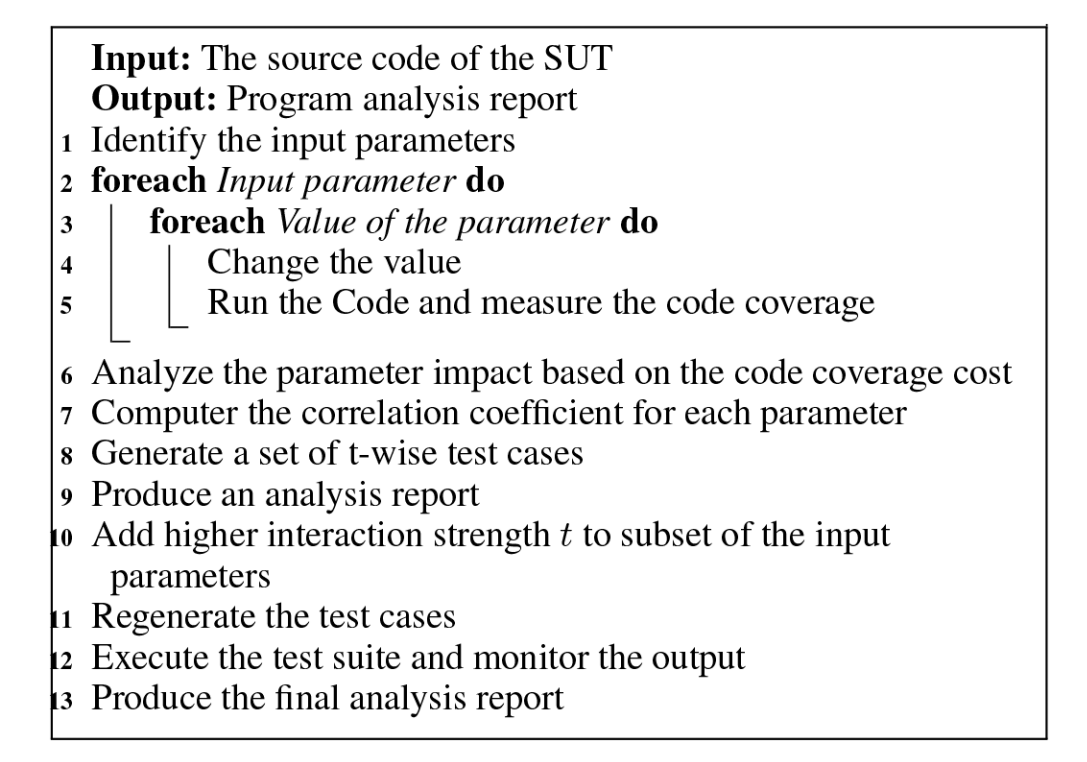

### Une autre technique de génération des pairs de paramètres
On peut également explorer le domaine des paramètres à l’aide de l’algorithme de recherche Cuckoo, une métaheuristique d’optimisation inspirée du comportement de reproduction de certains oiseaux, notamment le coucou. Cet algorithme repose sur la stratégie de ponte du coucou, qui consiste à déposer ses œufs dans les nids d’autres espèces, dans l’espoir qu’ils soient couvés et élevés comme leurs propres petits.

En transposant ce comportement à l’optimisation, chaque solution candidate est assimilée à un œuf : les meilleures solutions sont conservées, tandis que les moins performantes sont remplacées par de nouvelles solutions, générées aléatoirement ou par mutation.

Le Cuckoo Search combine ainsi une exploration globale de l’espace de recherche avec une exploitation fine des bonnes solutions, notamment grâce à l’utilisation des mouvements de Lévy. Le vol de Lévy est un type de marche aléatoire caractérisé par une combinaison de nombreux petits déplacements et de quelques sauts très longs, suivant une distribution à queue lourde (souvent une loi de puissance). Contrairement aux marches aléatoires classiques, comme le mouvement brownien où les pas sont de taille similaire et suivent une distribution gaussienne, le mouvement de Lévy permet des transitions brusques et lointaines, ce qui favorise une exploration plus efficace de l’espace de recherche.

L’approche Cuckoo Search s’avère ainsi particulièrement efficace pour l’optimisation de paramètres dans des espaces complexes et non linéaires. Dans notre cas, cela permet de mieux gérer les interactions non linéaires entre les paramètres et les contraintes, qui ajoutent une complexité significative à l’espace d’exploration.

In [16]:
def generate_cuckoo_test_suite(k, v, t=2, N=4, max_iter=1000):
    # All parameter pairs to cover (e.g., (0,1), (0,2), (1,2))
    parameter_pairs = [(i, j) for i in range(k) for j in range(i + 1, k)]

    # Required pairs: a dictionary of sets for each parameter pair (p1,p2)
    required_pairs = {}
    for p1, p2 in parameter_pairs:
        required_pairs[(p1, p2)] = set((x1, x2) for x1 in range(v) for x2 in range(v))

    # Initialize nests (candidate test cases)
    nests = [[random.randint(0, v - 1) for _ in range(k)] for _ in range(N)]

    # Current test suite (start with empty)
    test_suite = []

    # Track the number of uncovered pairs
    uncovered = sum(len(pairs) for pairs in required_pairs.values())

    for _ in range(max_iter):
        # Generate new cuckoos via Lévy flight (random perturbations)
        cuckoos = []
        for nest in nests:
            cuckoo = list(nest)
            # Randomly modify 1 parameter (Lévy flight approximation)
            param = random.randint(0, k - 1)
            cuckoo[param] = random.randint(0, v - 1)
            cuckoos.append(cuckoo)

        # Evaluate fitness: number of new uncovered pairs each test case covers
        candidates = nests + cuckoos
        fitness = []
        for candidate in candidates:
            covered = 0
            for p1, p2 in parameter_pairs:
                x1 = candidate[p1]
                x2 = candidate[p2]
                if (x1, x2) in required_pairs[(p1, p2)]:
                    covered += 1
            fitness.append(covered)

        # Select the best candidate (highest fitness)
        best_idx = fitness.index(max(fitness))
        best_candidate = candidates[best_idx]

        # Update test_suite and required_pairs
        test_suite.append(best_candidate)
        for p1, p2 in parameter_pairs:
            x1 = best_candidate[p1]
            x2 = best_candidate[p2]
            required_pairs[(p1, p2)].discard((x1, x2))

        # Check if all pairs are covered
        uncovered = sum(len(pairs) for pairs in required_pairs.values())
        if uncovered == 0:
            break

        # Replace a random nest with a new cuckoo if needed
        # Keep population diversity by replacing 10% of nests
        num_replacements = int(N * 0.1)
        for _ in range(num_replacements):
            nest_idx = random.randint(0, N - 1)
            nests[nest_idx] = [random.randint(0, v - 1) for _ in range(k)]

    # Return the minimal test suite that covers all pairs
    return test_suite[:N] if uncovered == 0 else "No solution found"

Voici un petit test sur lequel vous pourriez expérimenter avec différentes valeurs de v, k et N (vous obtenez différentes valeurs en relançant le même test):

In [17]:
k = 3
v = 2
N = 5
test_suite = generate_cuckoo_test_suite(k, v, N=N)
if test_suite != "No solution found":
    for case in test_suite:
        print(case)
    print("\n", len(test_suite), "tests")
else:
    print(test_suite)

[0, 0, 1]
[1, 1, 0]
[0, 1, 1]
[1, 0, 0]
[1, 1, 1]

 5 tests


Il devient intéressant de lancer plusieurs fois l'algorithme pour obtenir le meilleur résultat, surtout lorsqu'il s'agit de grands nombres de paramètres/valeurs et de stricts contraintes:

In [18]:
def is_pairwise_covered(matrix, v):
    k = len(matrix[0])  # Number of parameters (columns)
    # Iterate over all parameter pairs (i,j) where i < j
    for i in range(k):
        for j in range(i + 1, k):
            observed_pairs = set()
            # Collect all (value_i, value_j) pairs from the test cases
            for row in matrix:
                val_i = row[i]
                val_j = row[j]
                observed_pairs.add((val_i, val_j))
            # All possible pairs should be (a, b) for a in 0..v-1 and b in 0..v-1
            expected_pairs = {(a, b) for a in range(v) for b in range(v)}
            # Check if observed pairs match expected pairs
            if observed_pairs != expected_pairs:
                return False
    return True

def generate_cuckoo_test_suite_retries(k, v, retries=1, t=2, N=5, max_iter=10000):
    solutions = set()
    for _ in range(retries):
        test_suite = generate_cuckoo_test_suite(k, v, t, N, max_iter)
        if test_suite != "No solution found" and is_pairwise_covered(test_suite, v):
            # Convert to tuple to make it hashable for the set
            solutions.add(tuple(map(tuple, test_suite)))

    if not solutions:
        return "No solution found"

In [19]:
k = 3
v = 2
N = 5
generate_cuckoo_test_suite_retries(k, v, N)

if test_suite != "No solution found":
    for case in test_suite:
        print(case)
    print("\n", len(test_suite), "tests")
else:
    print(test_suite)

[0, 0, 1]
[1, 1, 0]
[0, 1, 1]
[1, 0, 0]
[1, 1, 1]

 5 tests
